# Estimating the counts of seals from citizen scientist tags for the entire Antarct continent
The code below calculates the estimated number of seals counted by citizen scientists, using the methods published in the paper “How many seals do you see? A method for correcting error and increasing reliability of Weddell seal numbers from citizen scientist counts of satellite images”, by L. Salas, M. LaRue, N. Nur, D.G. Ainley, S.E. Stammerjohn, J. Pennycook, J. Rotella, J.T. Paterson, K. Stamatiou, M. Dozier, J. Saints, and L. Barrington (submitted to Methds in Ecology and Evolution). Because some of the tagging campaigns were not very thorough, an enhancement to the calculation is used, and described in [this](https://docs.google.com/document/d/1q8ihZWXapZW8qtxUmmqdYD1gPEMlglG5nez8BBXPG7Q/edit?usp=sharing) document. 

## Preliminary dependencies: libraries and functions

In [3]:
libs<-c("ggplot2","plyr","dplyr","fitdistrplus")
lapply(libs, require, character.only = TRUE)
pathToLocalGit<-"/home/ec2-user/SageMaker/data_functions/"

######################  FUNCTIONS WE'LL NEED
source(paste0(pathToLocalGit,"countSealsFromTags_functions.R"))

Loading required package: fitdistrplus
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘fitdistrplus’”

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] FALSE

### Loading and preparing the data to calculate the estimates

In [4]:
## The taggerId of the expert:
mid<-21758509	## This is Michelle LaRue's tagger Id

## load the data
load(paste0(pathToLocalGit,"compiledData.RData"))


##############################
#prepare tag data for the count
tags<-unique(tags)
tgvutm<-merge(tags,views[,c("mapViewId","mapId","region")],by=c("mapViewId","region"),all.x=T)
tgvutm$numTags<-1
tgvutm$regionMapId<-paste0(tgvutm$region,tgvutm$mapId)

#prepare the feature data - for original approach
crt<-merge(crowd[,c("tagId","score","agremnt","sensor","region")],tgvutm[,c("tagId","mapViewId","easting","northing","region","regionTagId","regionMapViewId","regionTaggerId")],by=c("tagId","region"),all.x=T)
crt<-subset(crt,!is.na(mapViewId))
crtm<-merge(crt,views[,c("mapViewId","mapId","region")],by=c("mapViewId","region"),all.x=T)
crtm<-subset(crtm,!is.na(mapId))
crtm$numFeatures<-1
crtm$regionMapId<-paste0(crtm$region,crtm$mapId)

#prepare the tagger crowdrank data
rankdata<-taggers[,c("taggerId","taggerScore","region","regionTaggerId")]

#prepare the expert data
mlCounts<-aggregate(numTags~mapId+region+regionMapId,data=subset(tgvutm,taggerId==mid),FUN=sum)
names(mlCounts)<-c("mapId","region","regionMapId","mlcount")
mlMaps<-unique(subset(views,taggerId==mid))
mlMaps$regionMapId<-paste0(mlMaps$region,mlMaps$mapId)
tagsML<-subset(tgvutm,taggerId==mid)

#Subset the data to only those taggers that overlapped with the expert - find vews, maps, etc.
taggersSel<-unique(subset(views,regionMapId %in% mlMaps$regionMapId,select=c("taggerId","region","regionMapId","regionMapViewId","regionTaggerId")))
taggersSel<-subset(taggersSel,taggerId!=mid)		#taggers who share maps with ML
tagsSel<-subset(tgvutm,regionTaggerId %in% taggersSel$regionTaggerId) 
viewsSel<-subset(views,regionTaggerId %in% c(unique(taggersSel$regionTaggerId),mid))  

##Adding more stringent tagger quality filters
subtaggers<-subset(taggers,taggerScore>0.5 & numApprovedTags > 0)
subtaggers<-subset(subtaggers,regionTaggerId %in% taggersSel$regionTaggerId)   

## Estimate (aporx.) the probability of a feature being found on a map and the probability of a tag being placed on a map
totalMapsInspected<-NROW(unique(views$regionMapId))
totalMapsWtags<-NROW(unique(tgvutm$regionMapId))
totalMapsWfeat<-NROW(unique(crtm$regionMapId))
probFeatInMap<-totalMapsWfeat/totalMapsInspected
probTagInMap<-totalMapsWtags/totalMapsInspected
probTagAsFeat<-totalMapsWfeat/totalMapsWtags


############ Approximating ProbF and ProbS
## ProbF as the probability of placing a tag on a map: num maps with tags/ total num maps inspected
estProbF<-NROW(unique(tgvutm$regionMapId))/NROW(unique(maps$regionMapId))
## ProbS as the probability of ML finding a seal on a map
estProbS<-NROW(unique(tagsML$regionMapId))/NROW(unique(mlMaps$regionMapId))

(estCorr<-estProbS/estProbF)


[1] 1.763568

### Shrinking the estimates
In our original approach we assume a universal ProbS (see link to document above), and a tagger ProbT that is invariant for the tagger regardless of the map inspected. In this original approach, ProbF is the prob that any tag is found on a map. So, we define it as: ProbF (for each tagger separately) = number of  tags in maps inspected/total number of maps inspected. We know these two assumptions may not hold.

Here we estimate both the original correction factor (option 1) and the new Q correction coefficient (option 2). For these two approaches, we explore using estimates from each tagger that are region-specific (option 1A or 2A), or general for each tagger regardless of region (options 1B and 2B) 


In [5]:
## Version 1A: region-specific corrFactor estimates for each tagger
gspm<-getTaggerProbabilities_tagsOnlybyTag(rankdata=rankdata,crthr=0.5,taggersSel=subtaggers,tagsSel=tagsSel,tagsML=tagsML,viewsSel=viewsSel,ProbS=estProbS)

## Version 1B: single corrFactor estimate for each tagger
gspmG<-getTaggerProbabilities_tagsOnlybyTag_general(rankdata=rankdata,crthr=0.5,taggersSel=subtaggers,tagsSel=tagsSel,tagsML=tagsML,viewsSel=viewsSel,ProbS=estProbS)

## Option 2 - use Q: the correction coefficient (see link to document above)
## Version 2A: region-specific Qval estimates for each tagger
gspmQ<-getTaggerProbabilities_fromQ(rankdata=rankdata,crthr=0.5,taggersSel=subtaggers,tagsSel=tagsSel,tagsML=tagsML,mapsML=mlMaps,viewsSel=viewsSel)

## Version 2B: single Qval estimate for each tagger
gspmQG<-getTaggerProbabilities_fromQ_general(rankdata=rankdata,crthr=0.5,taggersSel=subtaggers,tagsSel=tagsSel,tagsML=tagsML,mapsML=mlMaps,viewsSel=viewsSel)

############################################################################
## Review the fits and estimates for the correction factors
## Option 1:
print("Option 1A: correction factor from region-specific estimates")
summary(gspm$corrFactor); print(paste("N:",nrow(gspm)))
print("")
print("Option 1B: correction factor from general estimates")
summary(gspmG$corrFactor); print(paste("N:",nrow(gspmG)))
print("")
############################################################################
## Review the fits and estimates for Qvals
## Option 2:
print("Option 2A: Q correction coefficients from region-specific estimates")
summary(gspmQ$Qval); print(paste("N:",nrow(gspmQ)))
print("")
print("Option 2B: Q correction coefficients from region-specific estimates")
summary(gspmQG$Qval); print(paste("N:",nrow(gspmQG)))


[1] "Option 1A: correction factor from region-specific estimates"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01616 0.29576 0.64071 1.08879 1.26525 9.04493 

[1] "N: 127"
[1] ""
[1] "Option 1B: correction factor from general estimates"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01616 0.30674 0.63638 1.22749 1.44031 9.04493 

[1] "N: 90"
[1] ""
[1] "Option 2A: Q correction coefficients from region-specific estimates"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01379 0.25236 0.45946 0.55121 0.78570 1.84314 

[1] "N: 135"
[1] ""
[1] "Option 2B: Q correction coefficients from region-specific estimates"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01379 0.29027 0.57169 0.68379 0.96343 2.94444 

[1] "N: 95"


### Review of results - fit probability density functions to the distribution of values
Here we review the results in more detail and fit PDFs to the data. We then decide on the most appropriate estimates to use, and the best PDF to use. 

#### Option 1: The correction factors
Though the region-specific and general estimates of the correction factor are equally dispersed, it is safe to assume that we should use the region-specific values because these are more numerous.

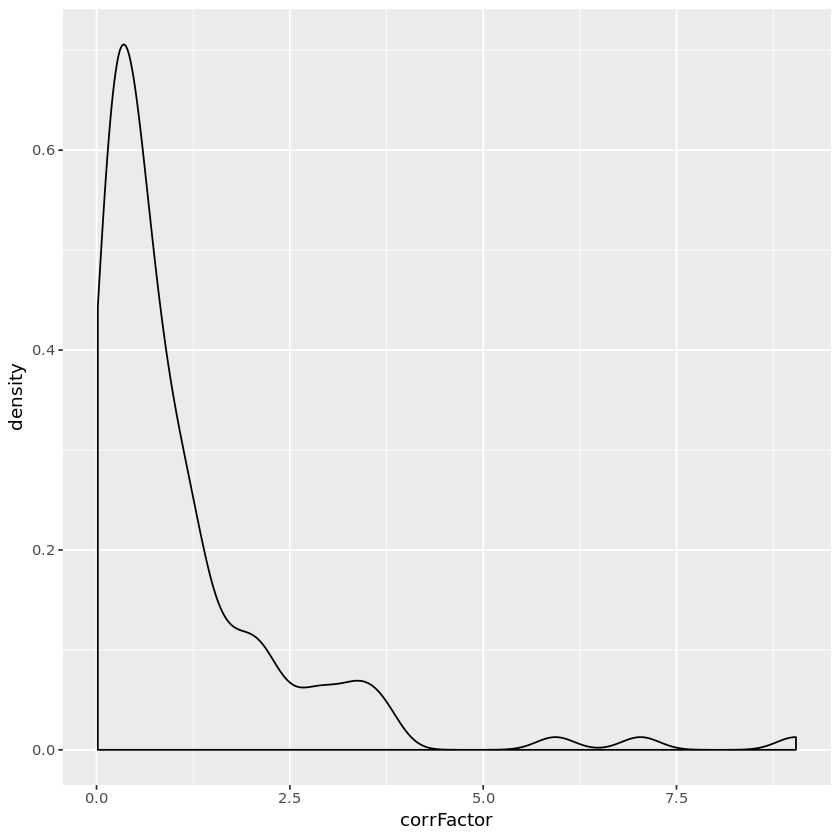

In [6]:
## Checking the distribution of these values
ggplot(gspm,aes(x=corrFactor)) + geom_density()

The above plot shows that it is safe to remove factors of value > 3.5%. There are only 3 of these. 

In [7]:
## Here removing the top 3 values
gspm<-subset(gspm,corrFactor < 3.5)

## Review the distribution fit options: log-normal, gamma or Weibull
print("Log-normal distribution fit:")
tstdist<-fitdist(log(gspm$corrFactor),"norm"); plot(tstdist)	#is log-normal best fit??

[1] "Log-normal distribution fit:"


ERROR: Error in fitdist(log(gspm$corrFactor), "norm"): could not find function "fitdist"


ERROR: Error in plot(tstdist): object 'tstdist' not found


[1] "Gamma distribution fit:"


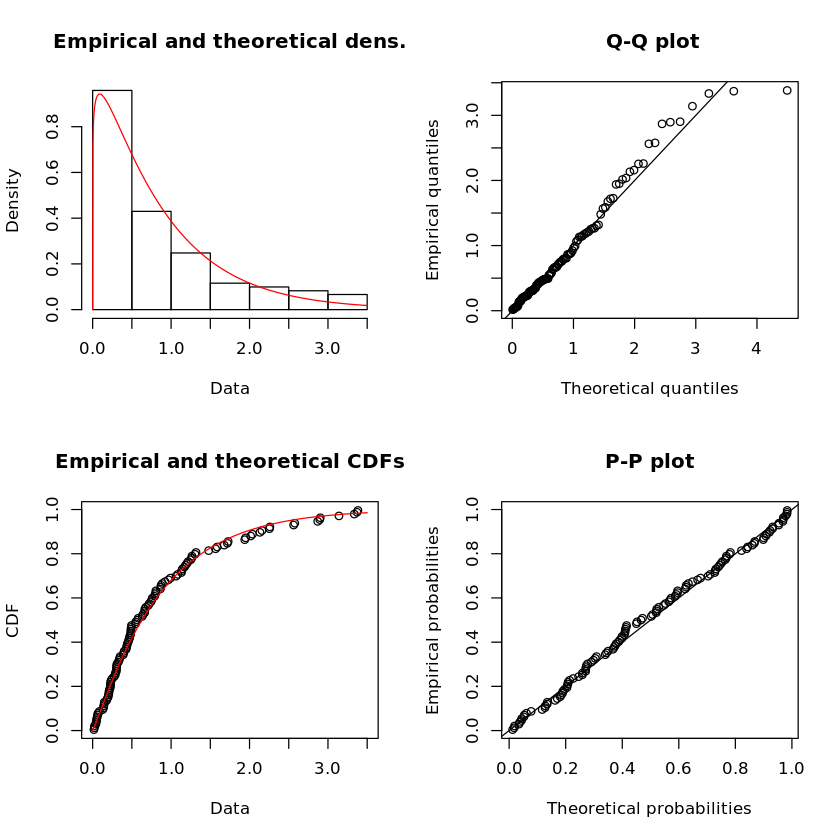

In [11]:
print("Gamma distribution fit:")
tstdist<-fitdist(gspm$corrFactor,"gamma"); plot(tstdist)	#I think gamma/weibull is best

[1] "Weibull distribution fit:"


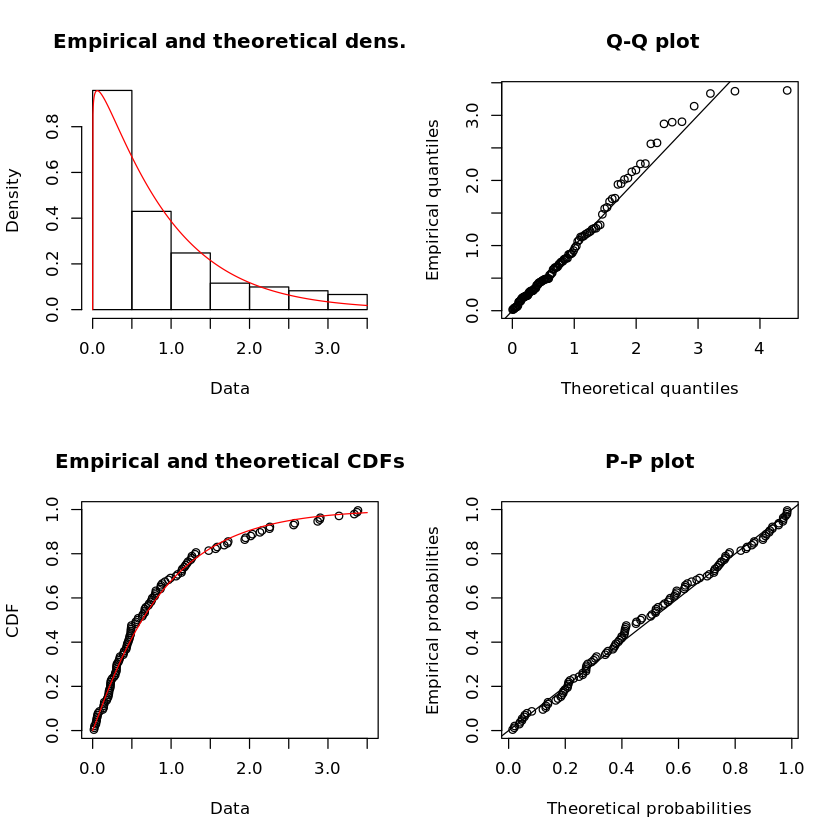

In [12]:
print("Weibull distribution fit:")
tstdist<-fitdist(gspm$corrFactor,"weibull"); plot(tstdist)

Below we compare the mean and limits of the correction factors for the Gamma and Log-normal distributions. The Gamma is a better fit. Using the gamma, the number of seals is anywhere from 3% to 300% of the tag counts, mean being 87%

In [14]:
## Checking to compare 95% confidence limits
cfdist<-fitdist(log(gspm$corrFactor),"norm")$estimate
# lower 95% - mean - upper 95%
print("Log-normal: lower95 - mean - upper95")
paste(round(exp(cfdist[1] - (1.96*cfdist[2])),3),"-",round(exp(cfdist[1]),3),"-",round(exp(cfdist[1] + (1.96*cfdist[2])),3))
# versus
print("Gamma: lower95 - mean - upper95")
cfdist<-fitdist(gspm$corrFactor,"gamma")$estimate
paste(round(qgamma(0.025,cfdist[1],cfdist[2]),3),"-",round(cfdist[1]/cfdist[2],3),"-",round(qgamma(0.975,cfdist[1],cfdist[2]),3))


[1] "Log-normal: lower95 - mean - upper95"


[1] "0.055 - 0.521 - 4.911"

[1] "Gamma: lower95 - mean - upper95"


[1] "0.03 - 0.869 - 3.062"

#### Option 2: the Q coefficients
As with the correction factors above, the the region-specific Q coefficient values are more numerous, but let's inspect the general values too.

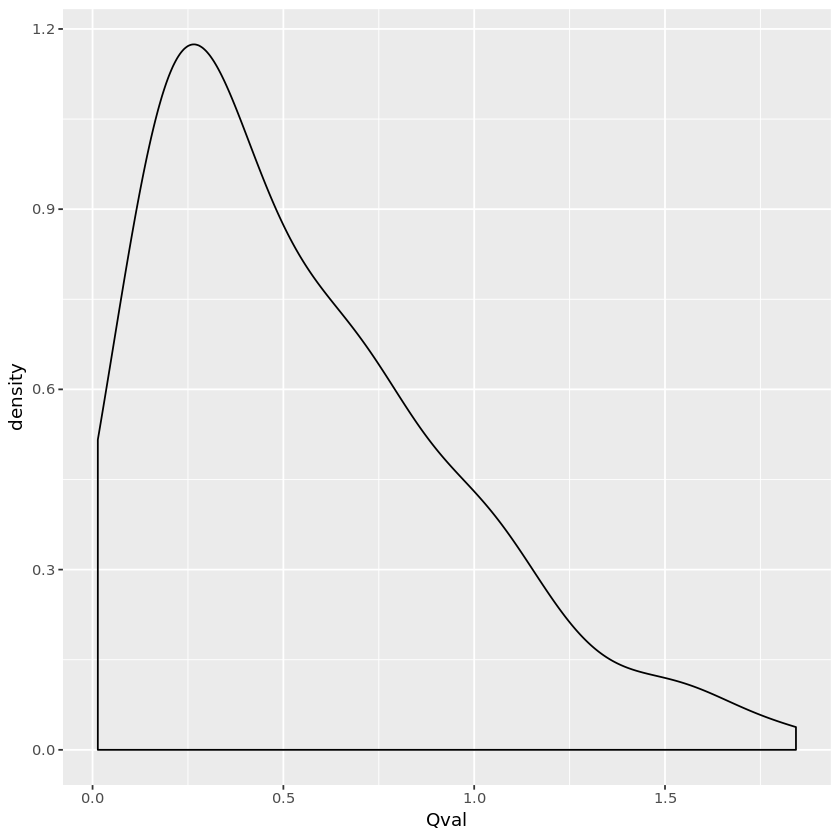

In [15]:
## Checking the distribution of the region-specific tagger values
ggplot(gspmQ,aes(x=Qval)) + geom_density()


No need to filter any values in the region-specific estimates of Qval.
Let's review the distribution fitting options for the region-specific Qval data:

[1] "Log-normal distribution fit:"


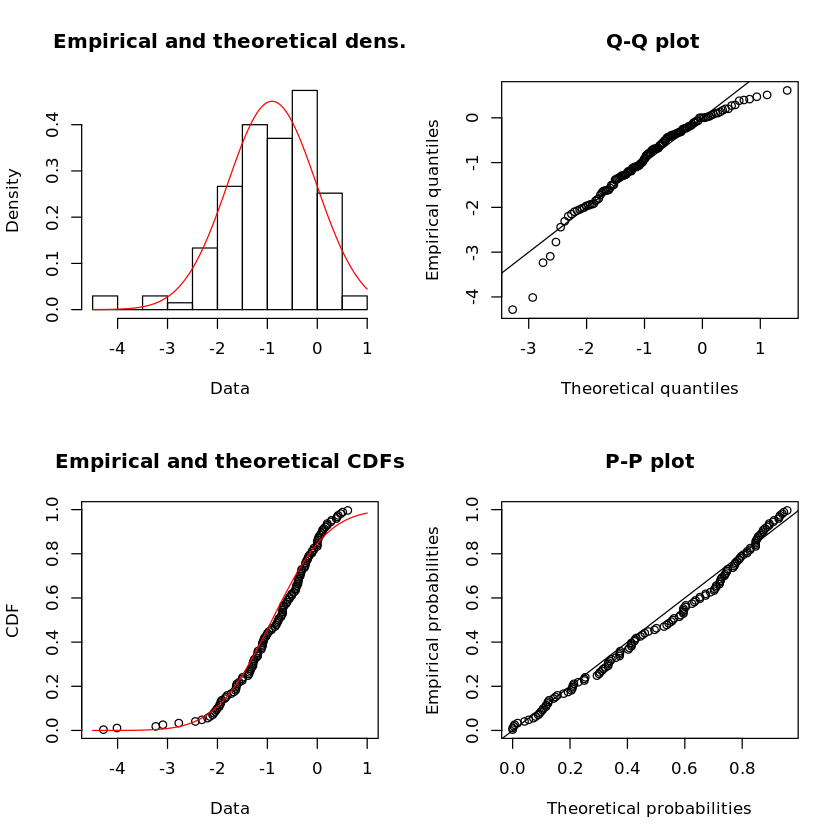

In [19]:
print("Log-normal distribution fit:")
tstdist<-fitdist(log(gspmQ$Qval),"norm"); plot(tstdist)

[1] "Gamma distribution fit:"


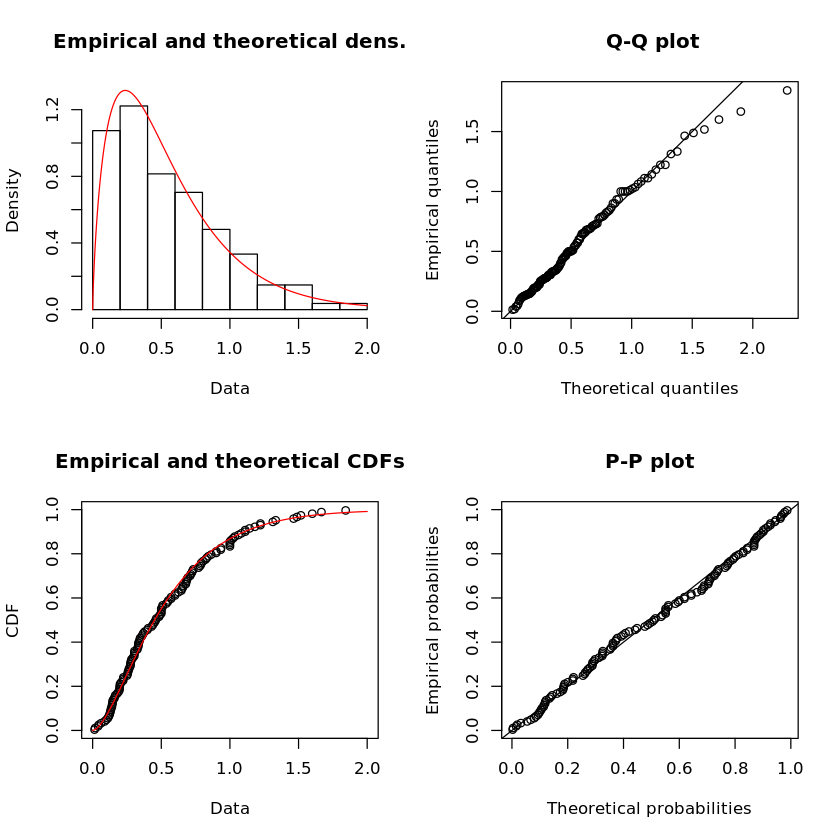

In [24]:
print("Gamma distribution fit:")
tstdist<-fitdist(gspmQ$Qval,"gamma"); plot(tstdist)

[1] "Weibull distribution fit:"


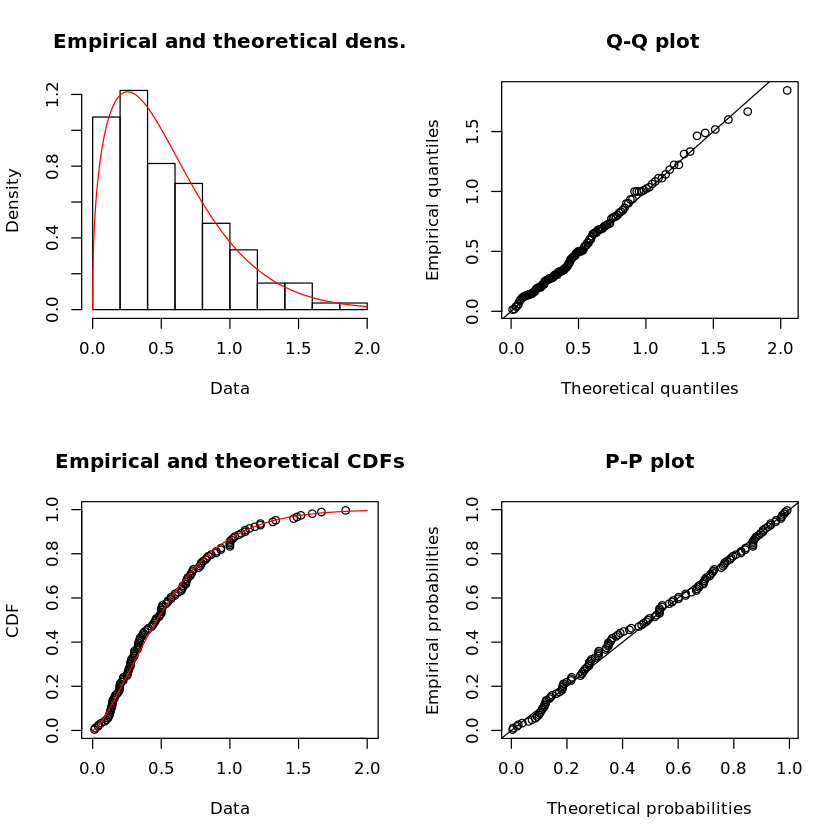

In [25]:
print("Weibull distribution fit:")
tstdist<-fitdist(gspmQ$Qval,"weibull"); plot(tstdist)

Weibull is certainly the best fit. So:

In [26]:
qdist<-fitdist(gspmQ$Qval,"weibull")$estimate
weimean<-qdist[2]*gamma(1+1/qdist[1])
print("Weibull: lower95 - mean - upper95")
paste(round(qweibull(0.025,qdist[1],qdist[2]),3),"-",round(weimean,3),"-",round(qweibull(0.975,qdist[1],qdist[2]),3))

[1] "Weibull: lower95 - mean - upper95"


[1] "0.045 - 0.552 - 1.525"

Let's now check the general Q coefficient estimates:

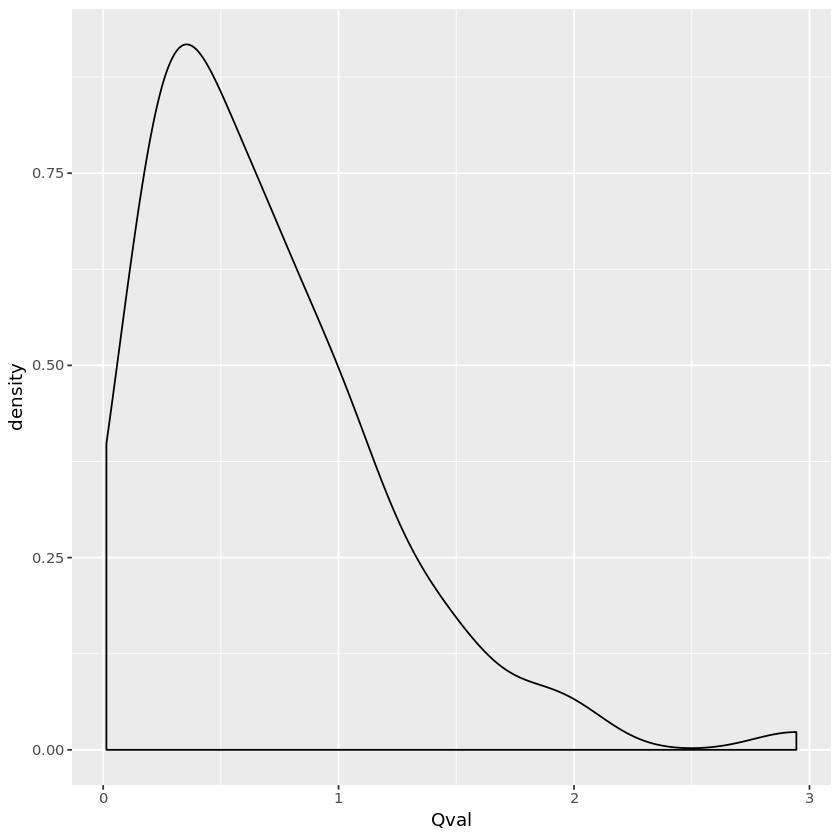

In [27]:
## Checking the distribution of the general tagger values
ggplot(gspmQG,aes(x=Qval)) + geom_density()

The density plot above plot shows that there is a single Qval value above 2.5 in the general estimates of Qval.
We filter that out as an outlier

In [ ]:
gspmQG<-subset(gspmQG,Qval<=2.5)

Let's review the distribution fitting options for the general Qval data:

[1] "Log-normal distribution fit:"


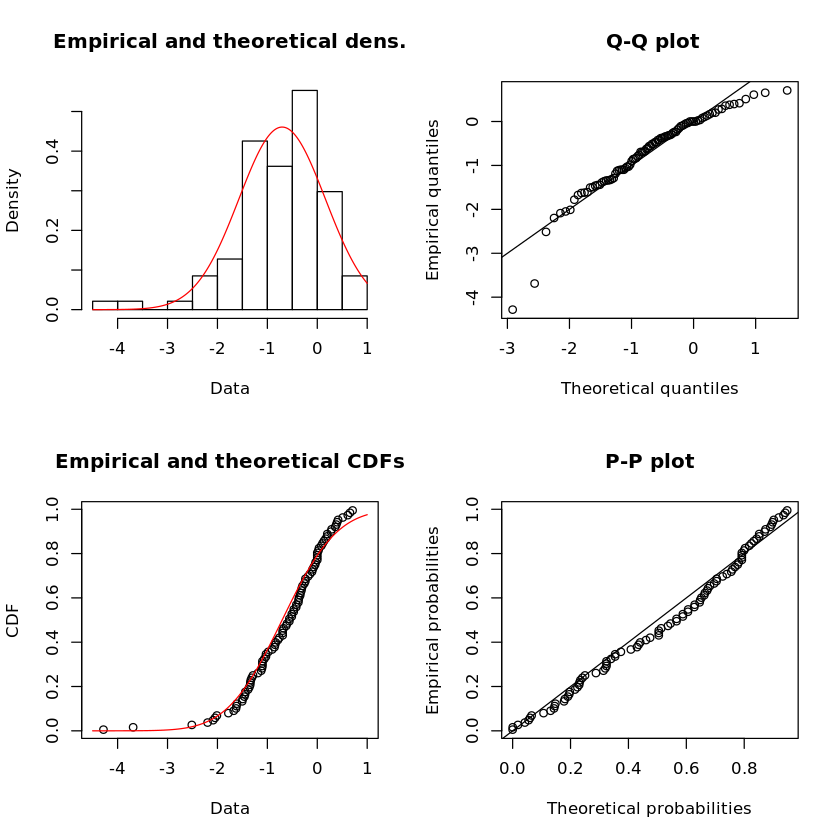

In [28]:
print("Log-normal distribution fit:")
tstdist<-fitdist(log(gspmQG$Qval),"norm"); plot(tstdist)

[1] "Gamma distribution fit:"


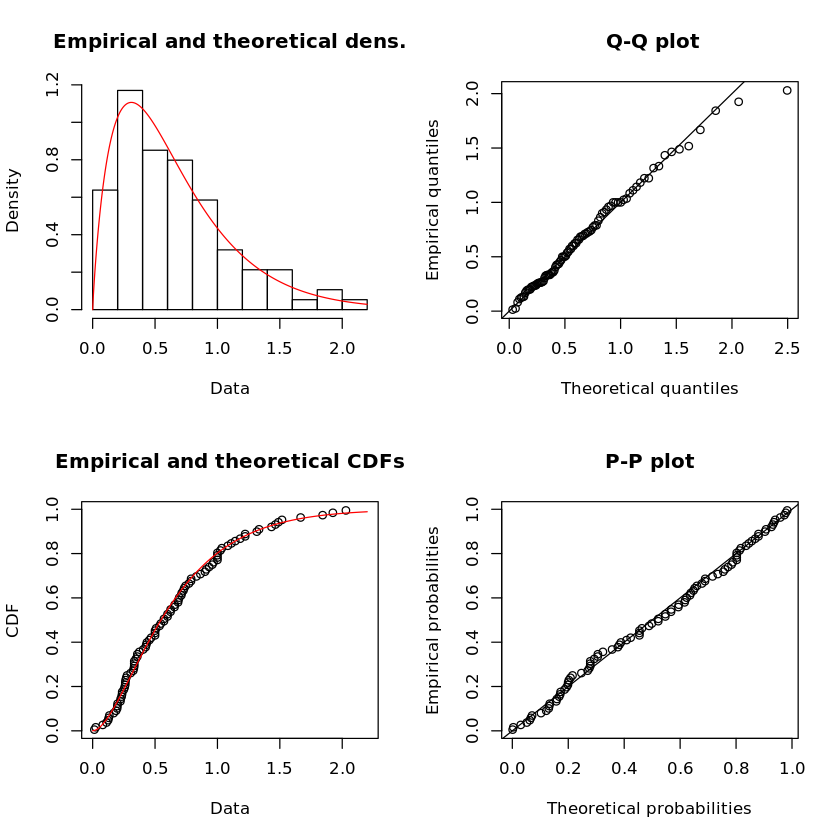

In [29]:
print("Gamma distribution fit:")
tstdist<-fitdist(gspmQG$Qval,"gamma"); plot(tstdist)

[1] "Weibull distribution fit:"


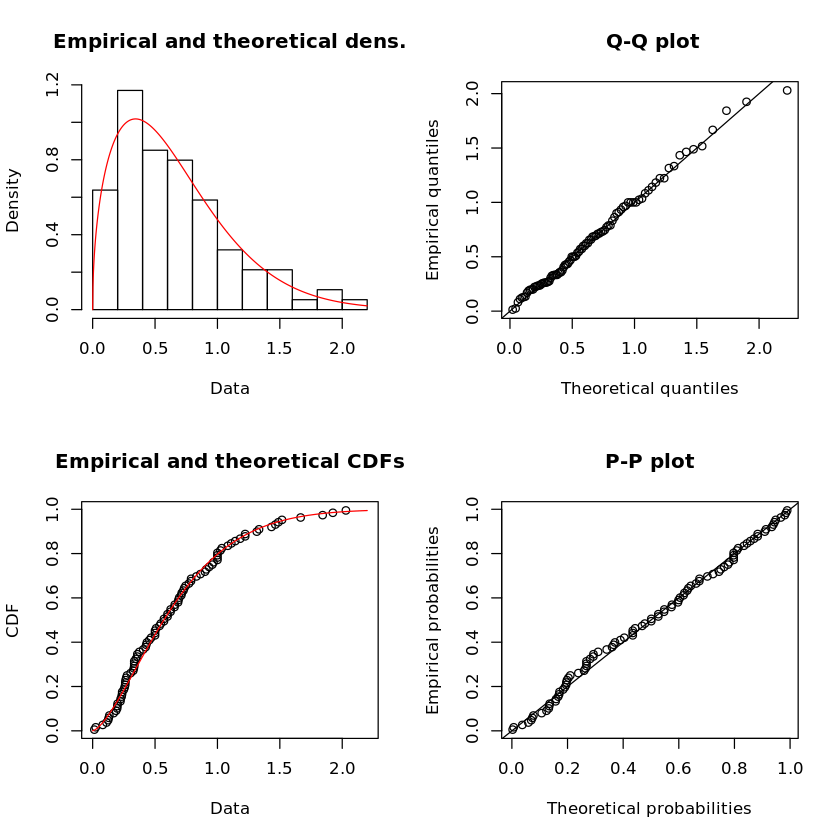

In [30]:
print("Weibull distribution fit:")
tstdist<-fitdist(gspmQG$Qval,"weibull"); plot(tstdist)

Nice! Again Weibull is the better fit. Then let's see the distribution values:

In [31]:
qdist<-fitdist(gspmQG$Qval,"weibull")$estimate
weimean<-qdist[2]*gamma(1+1/qdist[1])
print("Weibull: lower95 - mean - upper95")
paste(round(qweibull(0.025,qdist[1],qdist[2]),3),"-",round(weimean,3),"-",round(qweibull(0.975,qdist[1],qdist[2]),3))

[1] "Weibull: lower95 - mean - upper95"


[1] "0.061 - 0.66 - 1.758"

The general estimates are less numerous and more conservative than the region-specific estimates.

## Calculating the number of seals from the tags
Let's calculate seal numbers using the region-specific form:

In [32]:
countByQ<-getMapEstimates_fromQval(qdf=gspmQ,crthr=0.5,taggers=subtaggers,nSealsFilt=8,tgvutm=tgvutm,maps=maps,overlays=overlays,dist="weibull")
estByRegionQ<-as.data.frame(countByQ %>% group_by(region) %>% dplyr::summarize(lclNumSeals=ceiling(sum(lclNumSeals)),estNumSeals=ceiling(sum(estNumSeals)),uclNumSeals=ceiling(sum(uclNumSeals))))
estByRegionQ<-rbind(estByRegionQ,data.frame(region="Total",lclNumSeals=round(sum(countByQ$lclNumSeals)),estNumSeals=round(sum(countByQ$estNumSeals)),uclNumSeals=round(sum(countByQ$uclNumSeals))))
print(estByRegionQ)

  region lclNumSeals estNumSeals uclNumSeals
1    AMU         966        2376        6871
2    EA1        2166        5816       16772
3    EA2        2057        4871       14154
4    QMA        2632        7162       20678
5    RSS        4096       14337       40824
6    WAP        2826        8321       23804
7  Total       14743       42883      123103


If we were to use the general form:

In [33]:
countByQG<-getMapEstimates_fromQval(qdf=gspmQG,crthr=0.5,taggers=subtaggers,nSealsFilt=8,tgvutm=tgvutm,maps=maps,overlays=overlays,dist="weibull")
estByRegionQG<-as.data.frame(countByQG %>% group_by(region) %>% dplyr::summarize(lclNumSeals=ceiling(sum(lclNumSeals)),estNumSeals=ceiling(sum(estNumSeals)),uclNumSeals=ceiling(sum(uclNumSeals))))
estByRegionQG<-rbind(estByRegionQG,data.frame(region="Total",lclNumSeals=round(sum(countByQG$lclNumSeals)),estNumSeals=round(sum(countByQG$estNumSeals)),uclNumSeals=round(sum(countByQG$uclNumSeals))))
print(estByRegionQG)


  region lclNumSeals estNumSeals uclNumSeals
1    AMU        1003        2738        7478
2    EA1        2265        6713       18217
3    EA2        2107        5559       15237
4    QMA        2757        8339       22558
5    RSS        4461       16873       44847
6    WAP        2995        9651       25939
7  Total       15588       49873      134276


For comparison, let's see the estimates using the original correction factors:

In [34]:
countBySS<-getMapEstimates_byTag(gspm=gspm,tgvutm=tgvutm,maps=maps,overlays=overlays,mlCounts=mlCounts)
estByRegionSS<-as.data.frame(countBySS %>% group_by(region) %>% dplyr::summarize(lclNumSeals=ceiling(sum(lclNumSeals)),estNumSeals=ceiling(sum(estNumSeals)),uclNumSeals=ceiling(sum(uclNumSeals))))
estByRegionSS<-rbind(estByRegionSS,data.frame(region="Total",lclNumSeals=round(sum(countBySS$lclNumSeals)),estNumSeals=round(sum(countBySS$estNumSeals)),uclNumSeals=round(sum(countBySS$uclNumSeals))))
print(estByRegionSS)


  region lclNumSeals estNumSeals uclNumSeals
1    AMU          81        5073       18084
2    EA1         291       13633       48501
3    EA2         313       14413       51192
4    QMA         500       20944       74301
5    RSS         567       25973       92306
6    WAP         467       20327       72166
7  Total        2219      100363      356550


Unfortunately, the numbers using the original correction factor are probably incorrect. As evident in the graph below comparing estimates to the expert count, x5 times too high. So, we cannot work with the estimates from the original correction Factor because the sample of surveyors is too biased!
* The blue line is the 1:1 relationship, our expectation if the values are correct
* The red line is the resulting relationship. Note the substatial over-estimation

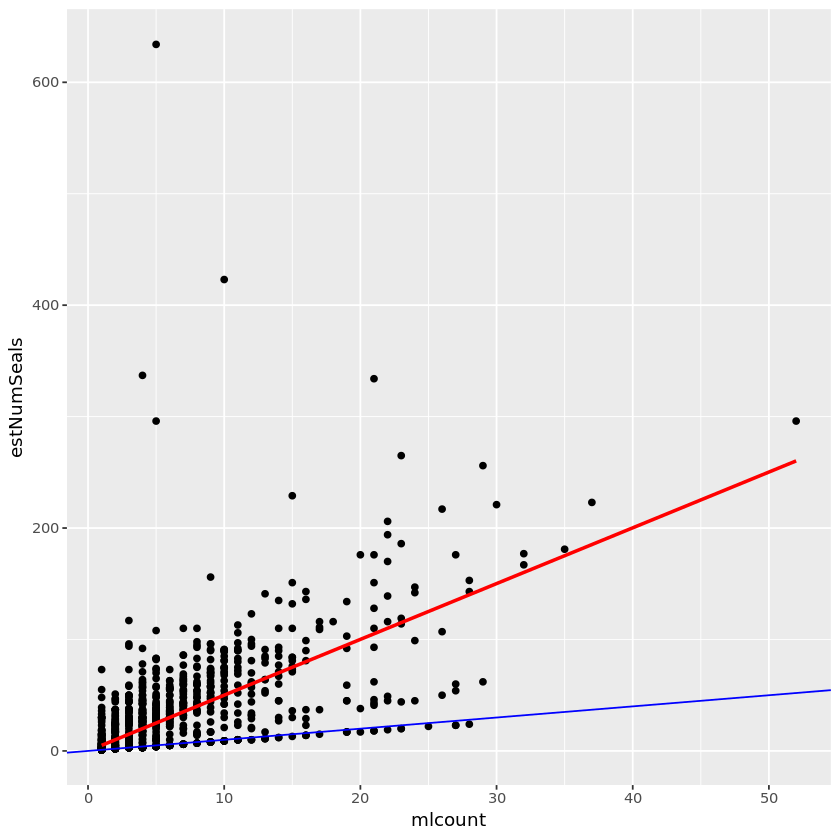

In [35]:
ggplot(subset(countBySS,!is.na(mlcount)),aes(x=mlcount,y=estNumSeals)) + geom_point() + geom_abline(slope=1,intercept=0, color="blue") + stat_smooth(method="lm",se=F, formula=y~x-1,color="red")

We can do the same evaluation for the Q coefficients from the region-specific estimates, and see that these seem to underestimate a little the true number of seals in images

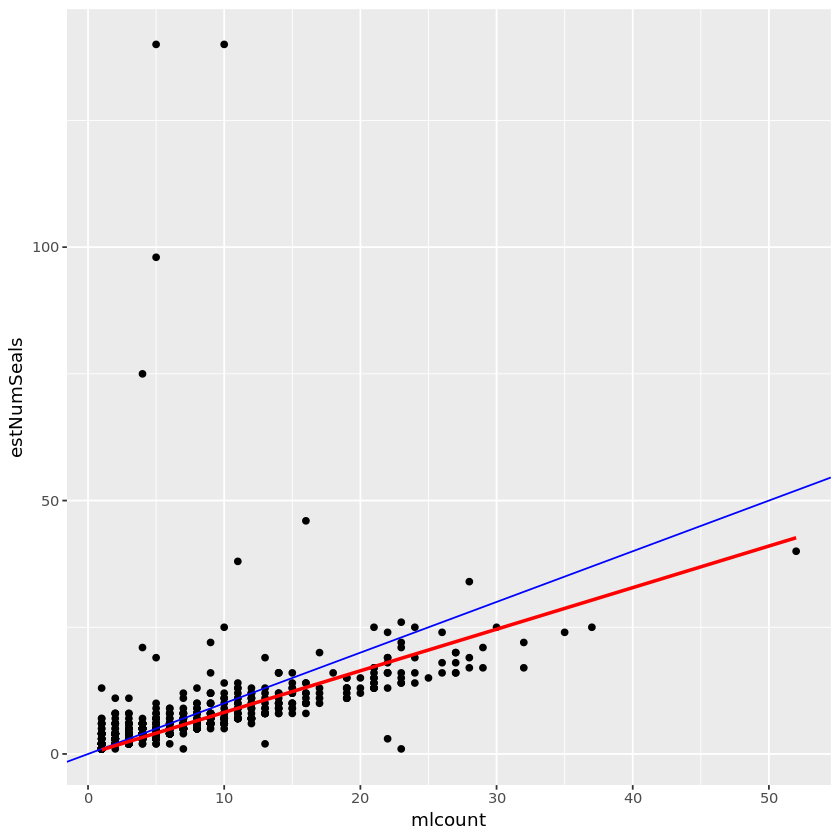

In [36]:
countByQ<-merge(countByQ,mlCounts[,c("regionMapId","mlcount")],by="regionMapId",all.x=T)
ggplot(subset(countByQ,!is.na(mlcount)),aes(x=mlcount,y=estNumSeals)) + geom_point() + geom_abline(slope=1,intercept=0, color="blue") + stat_smooth(method="lm",se=F, formula=y~x-1,color="red")


BUT... FORTUNATELY... using the general estimates for the Q coefficients works well!

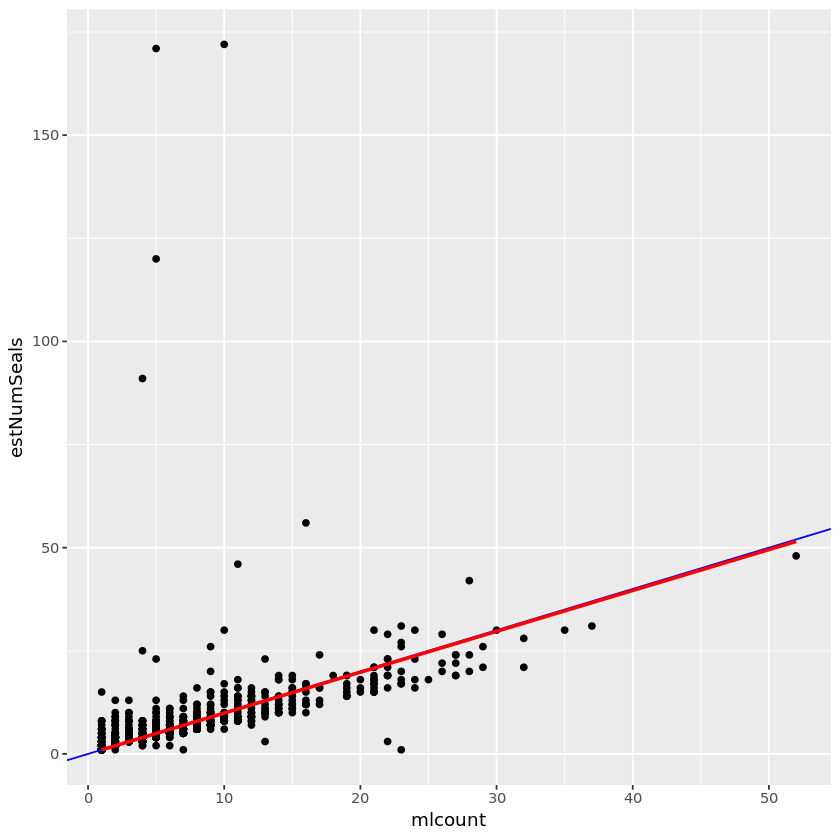

In [37]:
countByQG<-merge(countByQG,mlCounts[,c("regionMapId","mlcount")],by="regionMapId",all.x=T)
ggplot(subset(countByQG,!is.na(mlcount)),aes(x=mlcount,y=estNumSeals)) + geom_point() + geom_abline(slope=1,intercept=0, color="blue") + stat_smooth(method="lm",se=F, formula=y~x-1,color="red")


## Reviewing results
Note in the above graph that there are 6 points where there is substatial over-estimation.
We inspect these next. 
There are also 2 points where there is substantial under-estimation. We review these too.